In [8]:
import numpy as np
import matplotlib.pyplot as plt
from method import gaussian_domain, step_domain
import math



In [9]:
def dfdt(domain, dx, v0):
    return -1 * v0 * (domain - np.roll(domain, 1)) / dx

def explicit_euler(domain, dx, dt, v0):
    return domain + dt * dfdt(domain, dx, v0)

def rk2(domain, dx, dt, v0):
    k1 = dfdt(domain, dx, v0)
    k2 = dfdt(domain + k1 * dt, dx, v0)
    
    return domain + 0.5 * (k1 + k2) * dt

def rk4(domain, dx, dt, v0):
    k1 = dfdt(domain, dx, v0)
    k2 = dfdt(domain + k1 * dt / 2, dx, v0)
    k3 = dfdt(domain + k2 * dt / 2, dx, v0)
    k4 = dfdt(domain + k3 * dt, dx, v0)
    
    return domain + dt * (k1/6 + k2/3 + k3/3 + k4/6)


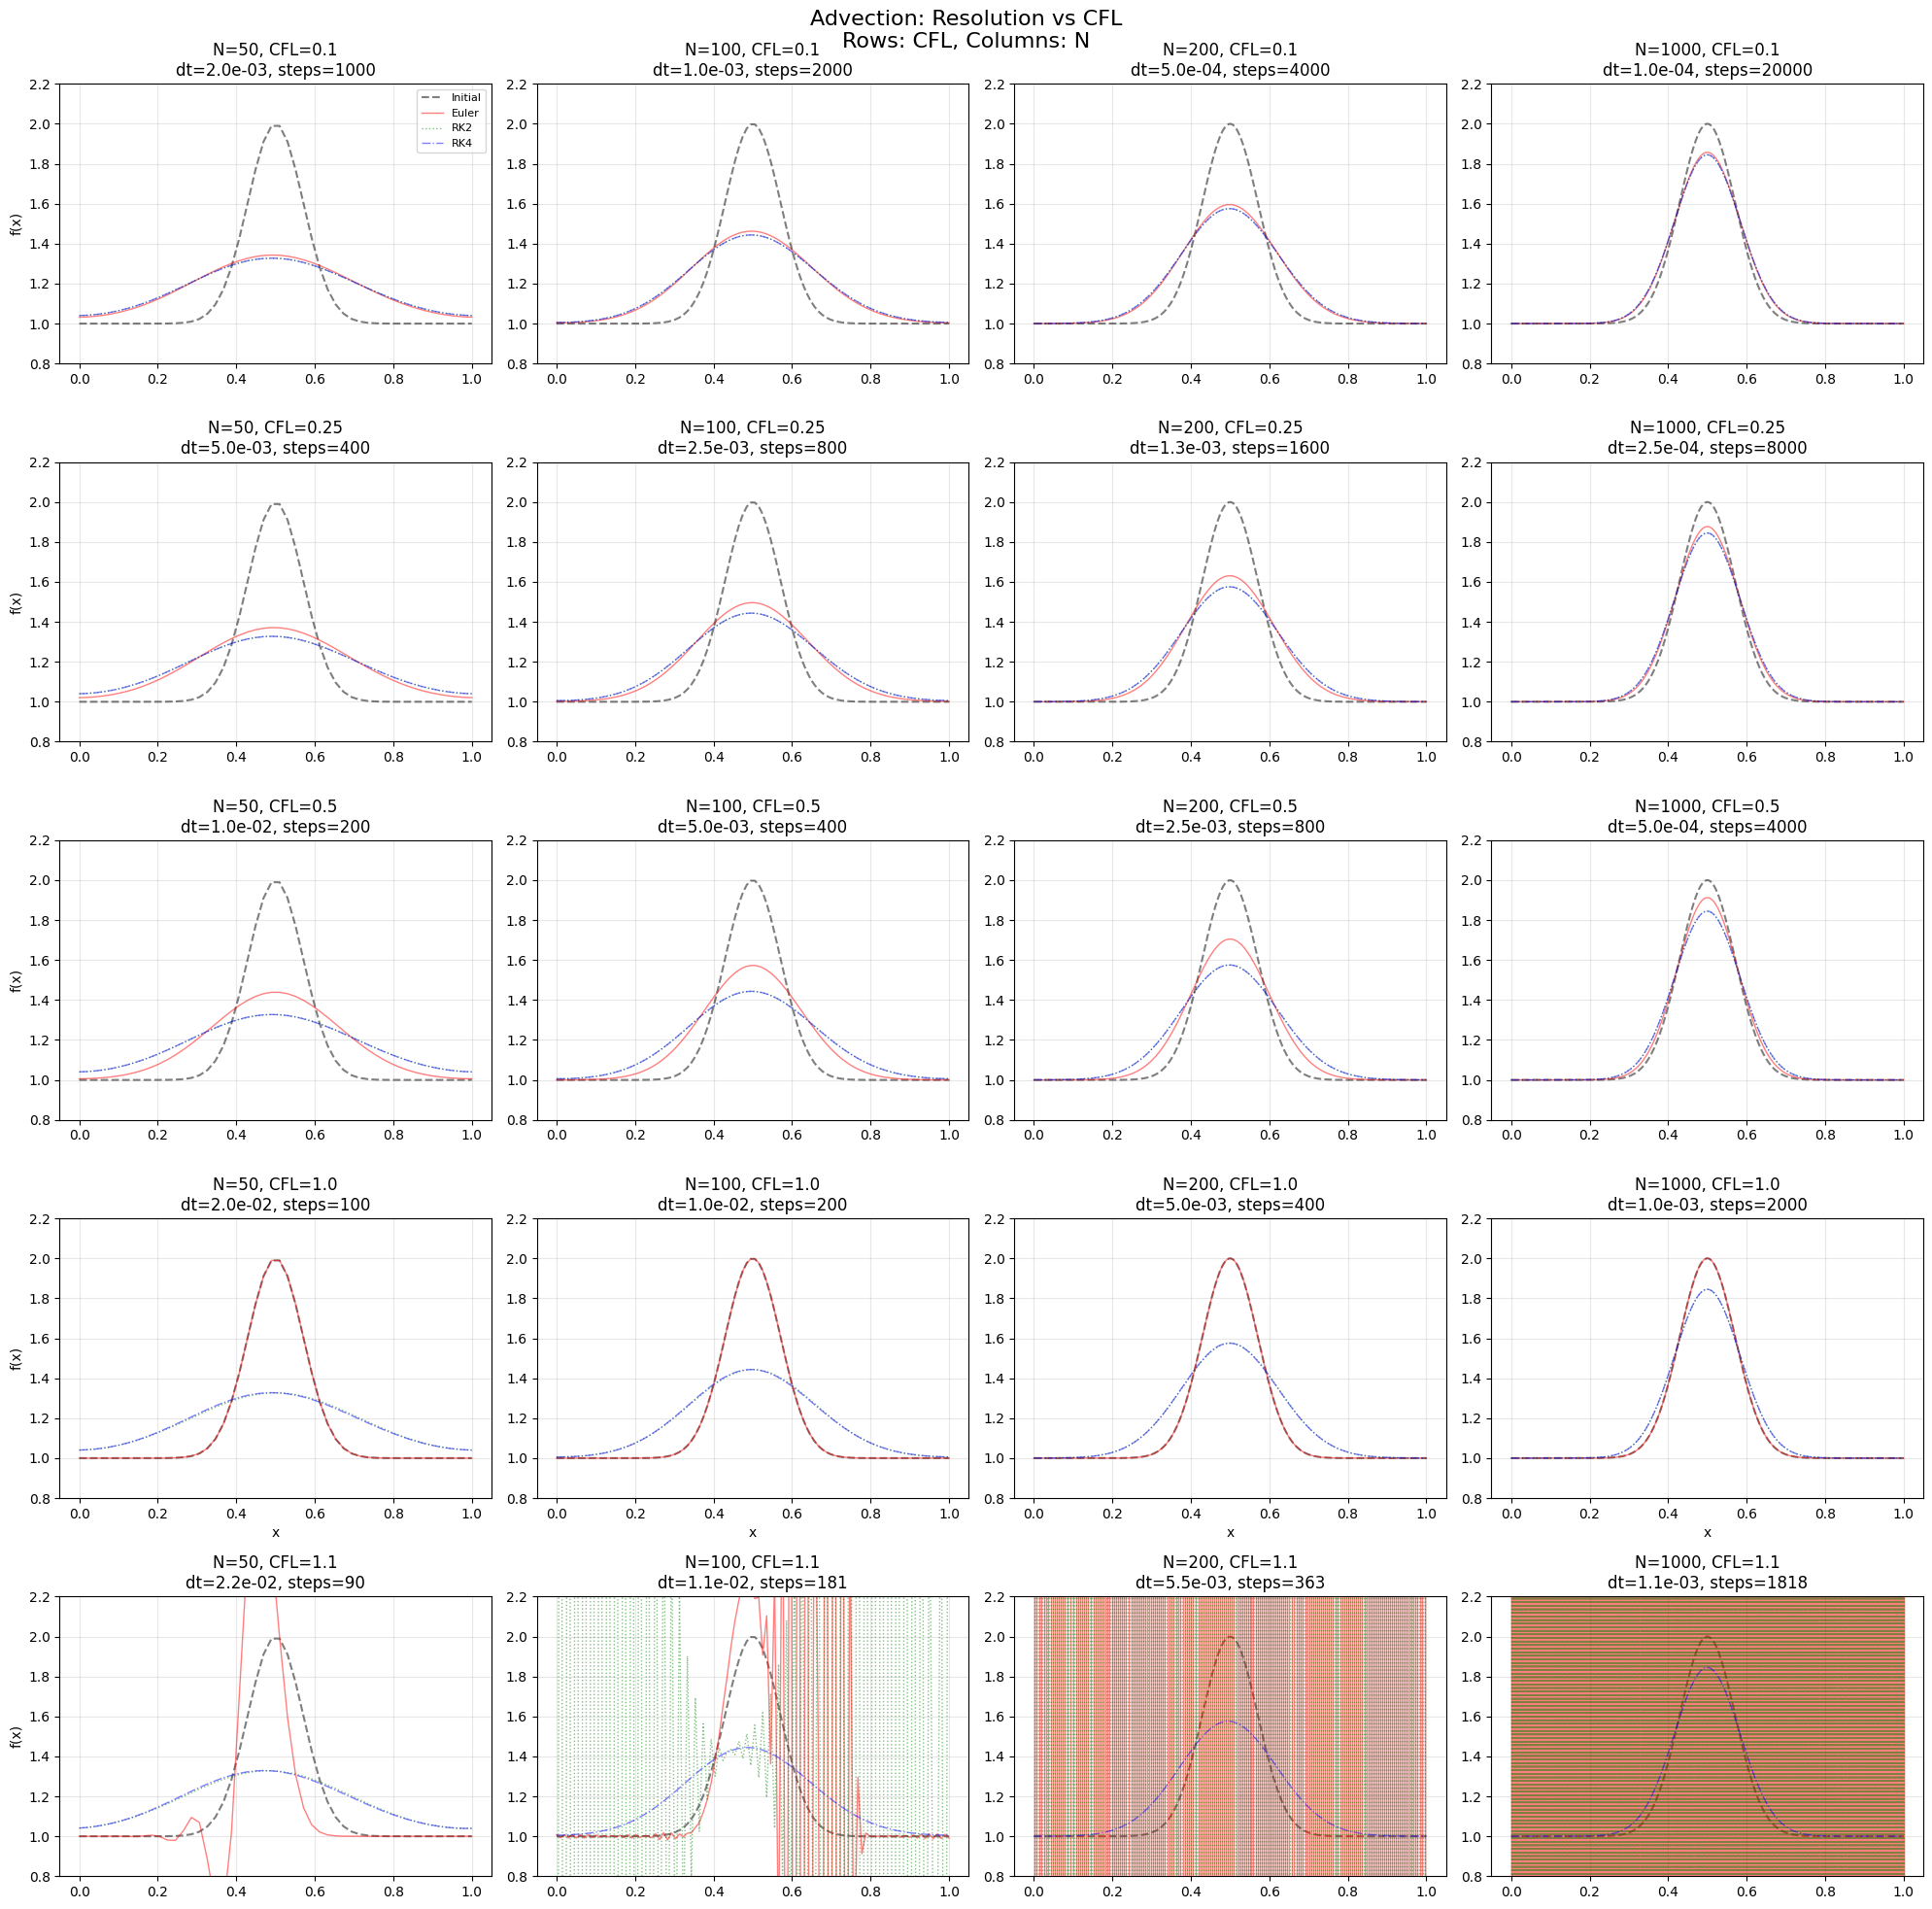

In [10]:
if True:
    # Parameters
    v0 = 1
    CFL_values = [0.1, 0.25, 0.5, 1.0, 1.1]
    N_values = [50, 100, 200, 1000]
    methods = [explicit_euler, rk2, rk4]
    method_names = ['Euler', 'RK2', 'RK4']
    colors = ['r', 'g', 'b']
    linestyles = ['-', ':', 'dashdot']
    total_time = 2.0  # Wave travels exactly 2 full domains

    # Create figure
    fig, axes = plt.subplots(5, 4, figsize=(20, 20))
    fig.suptitle('Advection: Resolution vs CFL\nRows: CFL, Columns: N', fontsize=16)

    for row, CFL in enumerate(CFL_values):
        for col, N in enumerate(N_values):
            ax = axes[row, col]
            
            # Setup
            dx = 1/N
            dt = CFL * dx / v0
            nsteps = int(total_time / dt)  # Same PHYSICAL time for all
            x, f0 = gaussian_domain(N)
            
            # Plot initial
            ax.plot(x, f0, 'k--', alpha=0.5, label='Initial')
            
            # Test each method
            for method, name, color, style in zip(methods, method_names, colors, linestyles):
                f = f0.copy()
                
                for step in range(nsteps):
                    f = method(f, dx, dt, v0)
                
                ax.plot(x, f, color, alpha=0.5, label=name, linewidth=1, linestyle=style)
            
            # Labels
            if row == 3:
                ax.set_xlabel('x')
            if col == 0:
                ax.set_ylabel('f(x)')
            
            ax.set_title(f'N={N}, CFL={CFL}\ndt={dt:.1e}, steps={nsteps}')
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0.8, 2.2])

    axes[0,0].legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.savefig('output/exercise11/exercise11_total_result_gaussian.pdf', dpi=1000)

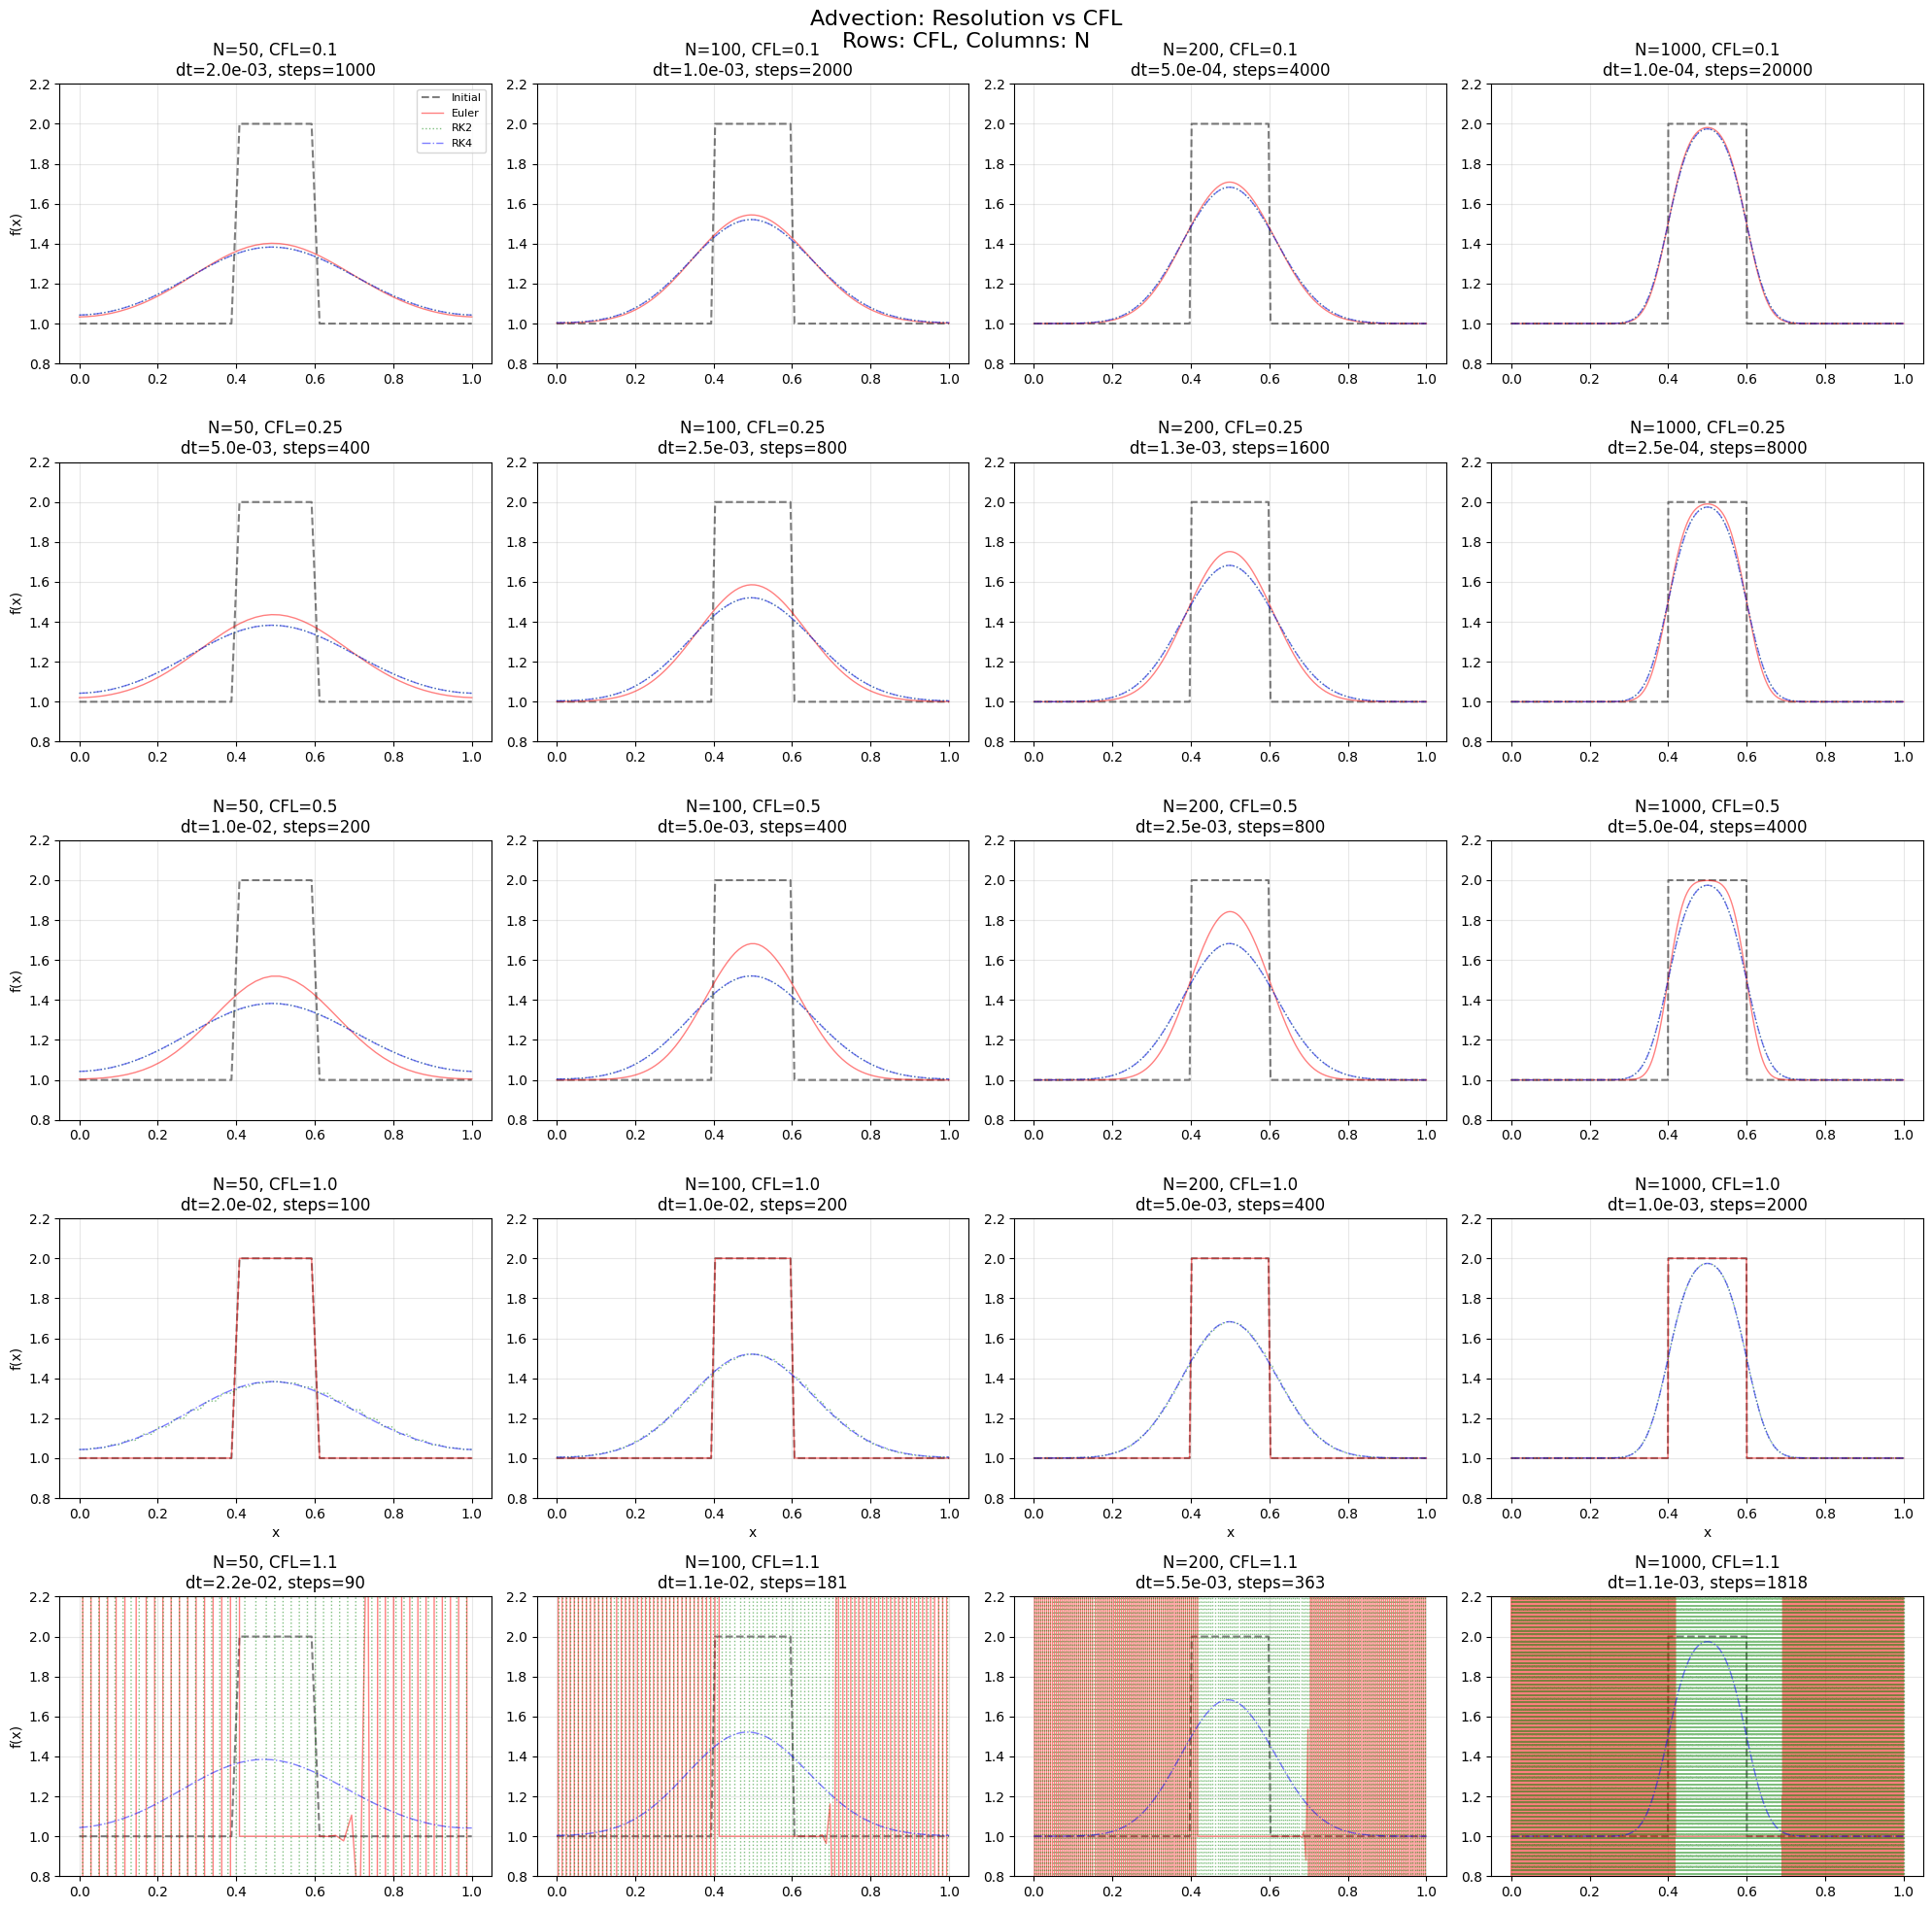

In [11]:
if True:
    # Parameters
    v0 = 1
    CFL_values = [0.1, 0.25, 0.5, 1.0, 1.1]
    N_values = [50, 100, 200, 1000]
    methods = [explicit_euler, rk2, rk4]
    method_names = ['Euler', 'RK2', 'RK4']
    colors = ['r', 'g', 'b']
    linestyles = ['-', ':', 'dashdot']
    total_time = 2.0  # Wave travels exactly 2 full domains

    # Create figure
    fig, axes = plt.subplots(5, 4, figsize=(20, 20))
    fig.suptitle('Advection: Resolution vs CFL\nRows: CFL, Columns: N', fontsize=16)

    for row, CFL in enumerate(CFL_values):
        for col, N in enumerate(N_values):
            ax = axes[row, col]
            
            # Setup
            dx = 1/N
            dt = CFL * dx / v0
            nsteps = int(total_time / dt)  # Same PHYSICAL time for all
            x, f0 = step_domain(N)
            
            # Plot initial
            ax.plot(x, f0, 'k--', alpha=0.5, label='Initial')
            
            # Test each method
            for method, name, color, style in zip(methods, method_names, colors, linestyles):
                f = f0.copy()
                
                for step in range(nsteps):
                    f = method(f, dx, dt, v0)
                
                ax.plot(x, f, color, alpha=0.5, label=name, linewidth=1, linestyle=style)
            
            # Labels
            if row == 3:
                ax.set_xlabel('x')
            if col == 0:
                ax.set_ylabel('f(x)')
            
            ax.set_title(f'N={N}, CFL={CFL}\ndt={dt:.1e}, steps={nsteps}')
            ax.grid(True, alpha=0.3)
            ax.set_ylim([0.8, 2.2])

    axes[0,0].legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.savefig('output/exercise11/exercise11_total_result_step.pdf', dpi=1000)

In [12]:
# now we implement the muscle scheme
def minmod(left_slope, right_slope):
    mask = left_slope * right_slope <= 0
    slope = np.where(abs(left_slope) < abs(right_slope), left_slope, right_slope)
    slope[mask] = 0
    return slope

def van_leer(left_slope, right_slope):
    mask = left_slope * right_slope <= 0
    slope = np.zeros_like(left_slope)
    slope[~mask] = 2 * left_slope[~mask] * right_slope[~mask] / (left_slope[~mask] + right_slope[~mask])
    return slope



def muscle_scheme_step(domain, dx, dt, v0, slope_limiter):
    # reconstruct f(x,t) within each cell by a linear function
    left_slope = (domain - np.roll(domain, 1)) / dx
    right_slope = (np.roll(domain, -1) - domain) / dx
    slope = slope_limiter(left_slope, right_slope)
    
    ## move this linear function to the right by v0 * dt / 2
    # these to values correspond the function values
    # on the left and right side of the interface
    # so f_left stores all values f_{i-1/2}
    # and f_right stores all values f_{i+1/2}
    f_left = domain + slope * (dx / 2 - v0 * dt / 2)
    #f_right = np.roll(domain + slope * (v0 * dt / 2), -1)
    
    # now we use the left value for the flux since v0 > 0
    flux = v0 * f_left
    
    updated_domain = domain - dt/dx * (flux - np.roll(flux, 1))
    
    return updated_domain


def muscle_scheme(initial_condition, N, CFL, v0, total_time, slope_limiter):
    x, domain = initial_condition(N)

    dx = 1 / N
    dt = CFL * dx / v0

    steps = int(total_time / dt)
    for _ in range(steps):
        domain = muscle_scheme_step(domain, dx, dt, v0, slope_limiter)

    return x, domain

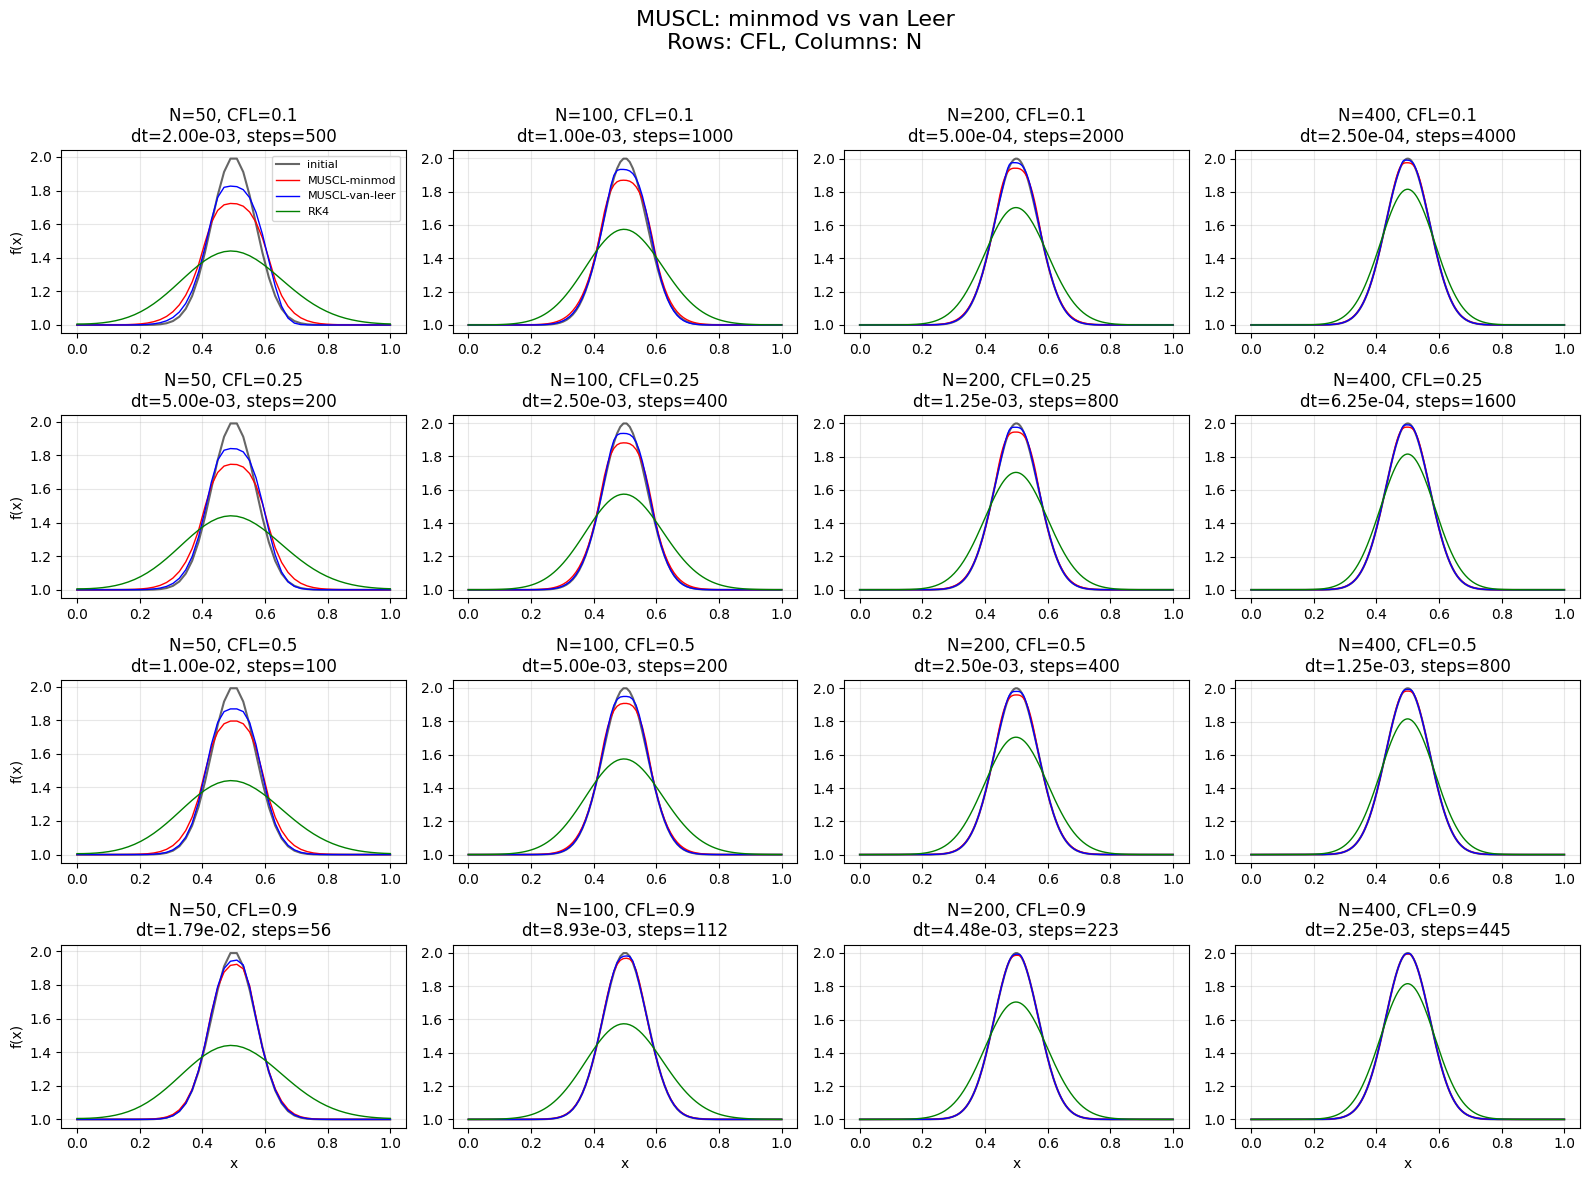

In [13]:
# 4x4 comparison: vary N (cols) and CFL (rows).
# For each (N,CFL) we adjust dt so that total_time/dt is an integer:
# nsteps = ceil(total_time / (CFL*dx/v0)) and dt = total_time / nsteps.
N_values = [50, 100, 200, 400]
CFL_values = [0.1, 0.25, 0.5, 0.9]
v0 = 1.0
total_time = 1.0
ic = gaussian_domain

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
fig.suptitle('MUSCL: minmod vs van Leer\nRows: CFL, Columns: N', fontsize=16)

for i, CFL in enumerate(CFL_values):
    for j, N in enumerate(N_values):
        ax = axes[i, j]
        dx = 1.0 / N
        # initial dt from CFL, then pick nsteps so total_time/dt integer
        dt_init = CFL * dx / v0
        nsteps = int(np.ceil(total_time / dt_init))
        dt = total_time / nsteps

        x, f0 = ic(N)
        ax.plot(x, f0, 'k-', alpha=0.6, label='initial')

        # Evolve using MUSCL + minmod
        f = f0.copy()
        for _ in range(nsteps):
            f = muscle_scheme_step(f, dx, dt, v0, minmod)
        ax.plot(x, f, 'r', label='MUSCL-minmod', linewidth=1)

        # Evolve using MUSCL + van Leer
        f = f0.copy()
        for _ in range(nsteps):
            f = muscle_scheme_step(f, dx, dt, v0, van_leer)
        ax.plot(x, f, 'b', label='MUSCL-van-leer', linewidth=1)

        # Evolve using RK4 (upwind finite-difference dfdt)
        f = f0.copy()
        for _ in range(nsteps):
            f = rk4(f, dx, dt, v0)
        ax.plot(x, f, 'g', label='RK4', linewidth=1)

        ax.set_title(f'N={N}, CFL={CFL}\ndt={dt:.2e}, steps={nsteps}')
        ax.grid(True, alpha=0.3)
        if i == 3:
            ax.set_xlabel('x')
        if j == 0:
            ax.set_ylabel('f(x)')

# Add a legend to the top-left subplot
axes[0,0].legend(loc='upper right', fontsize=8)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig('output/exercise12/muscl_rk4_4x4_compare_gauss.png', dpi=1000)
plt.show()


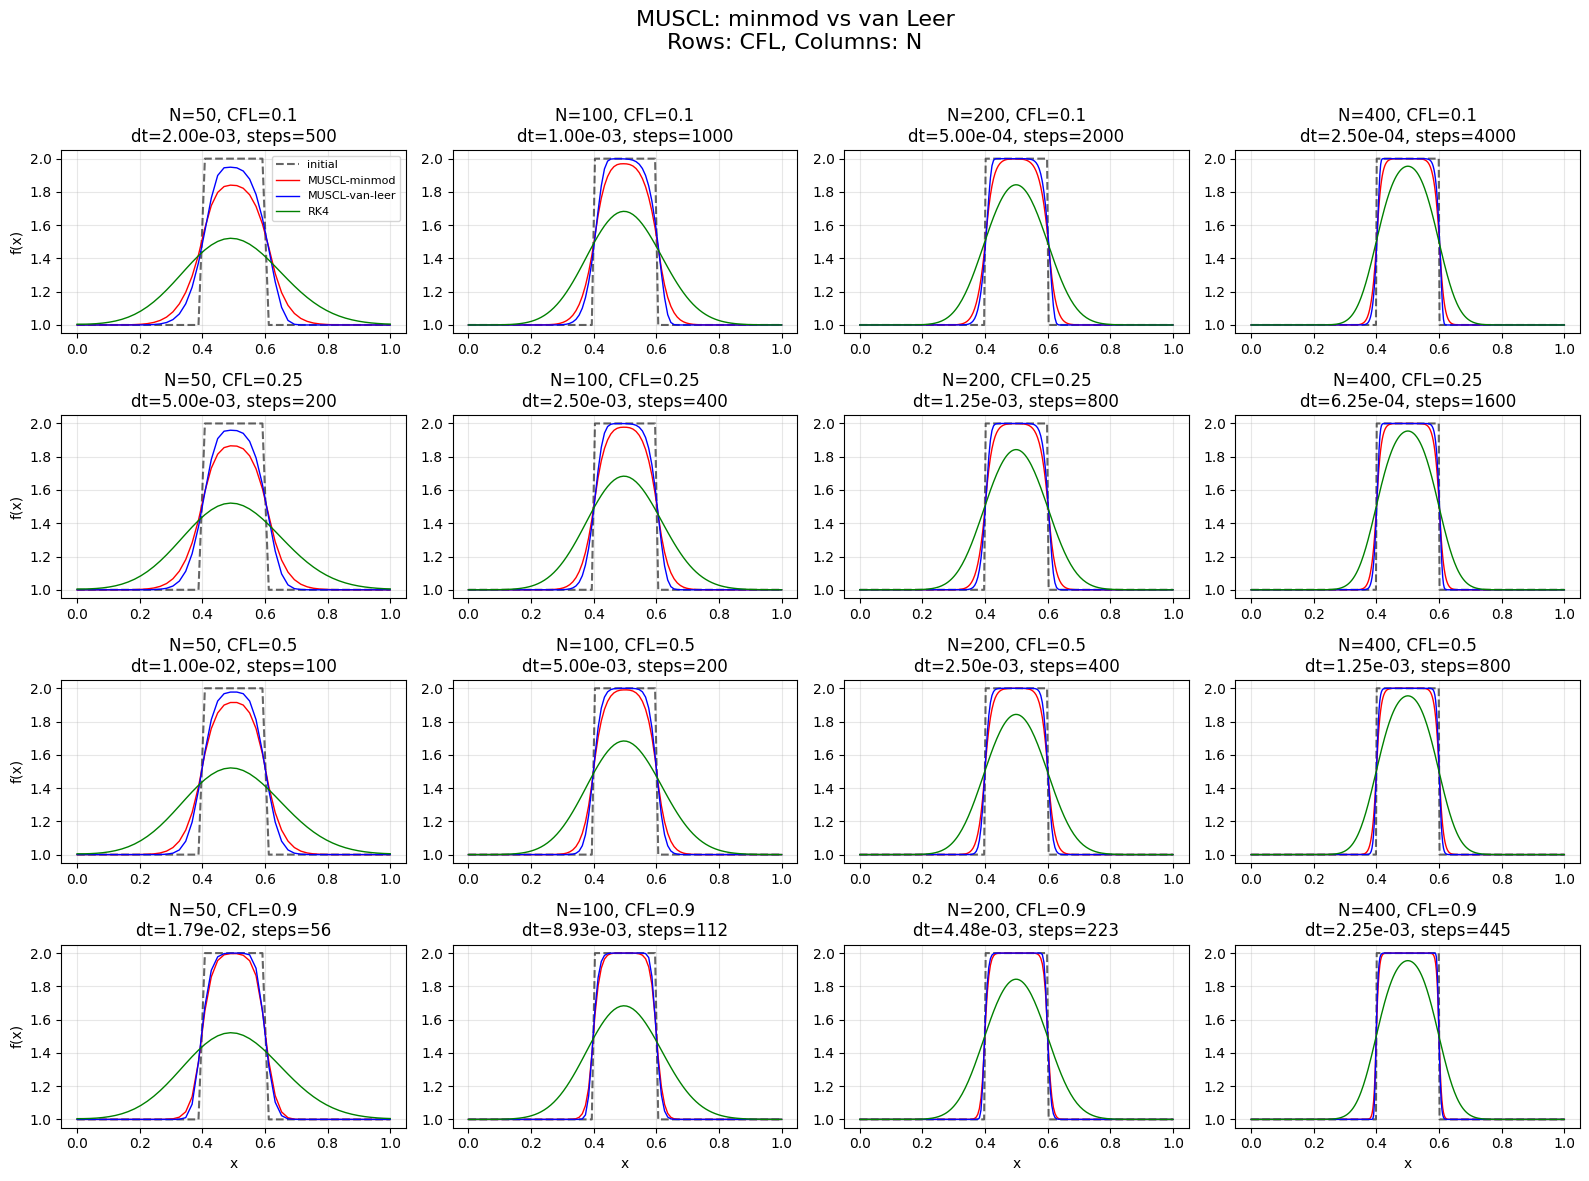

In [14]:
# 4x4 comparison: vary N (cols) and CFL (rows).
# For each (N,CFL) we adjust dt so that total_time/dt is an integer:
# nsteps = ceil(total_time / (CFL*dx/v0)) and dt = total_time / nsteps.
N_values = [50, 100, 200, 400]
CFL_values = [0.1, 0.25, 0.5, 0.9]
v0 = 1.0
total_time = 1.0
ic = step_domain

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
fig.suptitle('MUSCL: minmod vs van Leer\nRows: CFL, Columns: N', fontsize=16)

for i, CFL in enumerate(CFL_values):
    for j, N in enumerate(N_values):
        ax = axes[i, j]
        dx = 1.0 / N
        # initial dt from CFL, then pick nsteps so total_time/dt integer
        dt_init = CFL * dx / v0
        nsteps = int(np.ceil(total_time / dt_init))
        dt = total_time / nsteps

        x, f0 = ic(N)
        ax.plot(x, f0, 'k--', alpha=0.6, label='initial')

        # Evolve using MUSCL + minmod
        f = f0.copy()
        for _ in range(nsteps):
            f = muscle_scheme_step(f, dx, dt, v0, minmod)
        ax.plot(x, f, 'r', label='MUSCL-minmod', linewidth=1)

        # Evolve using MUSCL + van Leer
        f = f0.copy()
        for _ in range(nsteps):
            f = muscle_scheme_step(f, dx, dt, v0, van_leer)
        ax.plot(x, f, 'b', label='MUSCL-van-leer', linewidth=1)

        # Evolve using RK4 (upwind finite-difference dfdt)
        f = f0.copy()
        for _ in range(nsteps):
            f = rk4(f, dx, dt, v0)
        ax.plot(x, f, 'g', label='RK4', linewidth=1)

        ax.set_title(f'N={N}, CFL={CFL}\ndt={dt:.2e}, steps={nsteps}')
        ax.grid(True, alpha=0.3)
        if i == 3:
            ax.set_xlabel('x')
        if j == 0:
            ax.set_ylabel('f(x)')

# Add a legend to the top-left subplot
axes[0,0].legend(loc='upper right', fontsize=8)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig('output/exercise12/muscl_rk4_4x4_compare_step.png', dpi=1000)
plt.show()
